In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [9]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [10]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [11]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [12]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [13]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [14]:
df = read_csv_replace_missing_by_polynomial('idh_educacao.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1991,0.518,0.442,0.605,0.645,0.511,0.502,0.774,0.661,0.653,0.458,...,0.677,0.749,0.519,0.622,0.618,0.725,0.722,0.515,0.729,0.534
2012,0.649,0.587,0.632,0.659,0.593,0.667,0.768,0.692,0.698,0.611,...,0.718,0.703,0.617,0.637,0.746,0.674,0.74,0.607,0.792,0.676
2013,0.658,0.573,0.659,0.714,0.594,0.667,0.794,0.701,0.71,0.639,...,0.737,0.715,0.642,0.612,0.735,0.691,0.757,0.598,0.8,0.691
2014,0.679,0.599,0.667,0.688,0.619,0.679,0.791,0.709,0.723,0.639,...,0.747,0.736,0.668,0.627,0.757,0.699,0.768,0.625,0.813,0.729
2015,0.679,0.605,0.686,0.69,0.64,0.689,0.789,0.726,0.722,0.649,...,0.747,0.752,0.683,0.664,0.758,0.717,0.769,0.633,0.811,0.707
2016,0.704,0.635,0.705,0.709,0.656,0.708,0.822,0.732,0.754,0.673,...,0.773,0.757,0.676,0.691,0.771,0.722,0.785,0.625,0.837,0.723
2017,0.671,0.634,0.732,0.7,0.655,0.715,0.797,0.731,0.743,0.684,...,0.764,0.762,0.677,0.699,0.764,0.727,0.778,0.639,0.826,0.729
2018,0.706,0.651,0.717,0.742,0.66,0.74,0.808,0.743,0.757,0.685,...,0.777,0.781,0.69,0.705,0.774,0.736,0.78,0.66,0.829,0.741


In [15]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2012)) + list(range(2022,2023))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

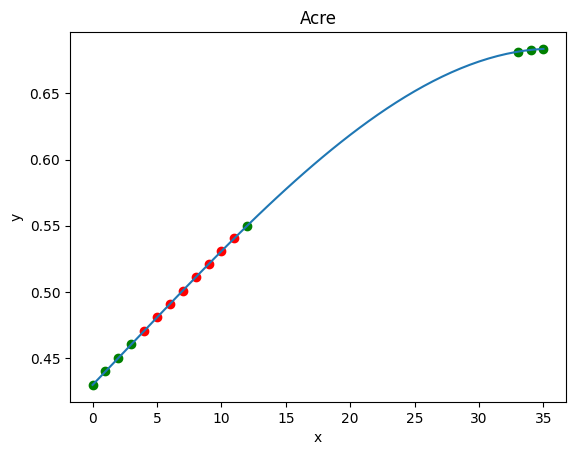

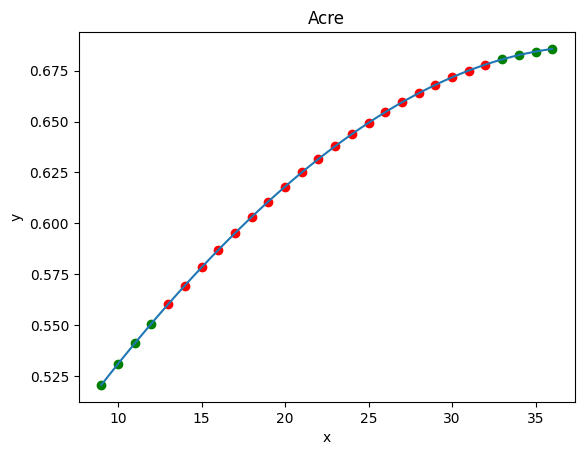

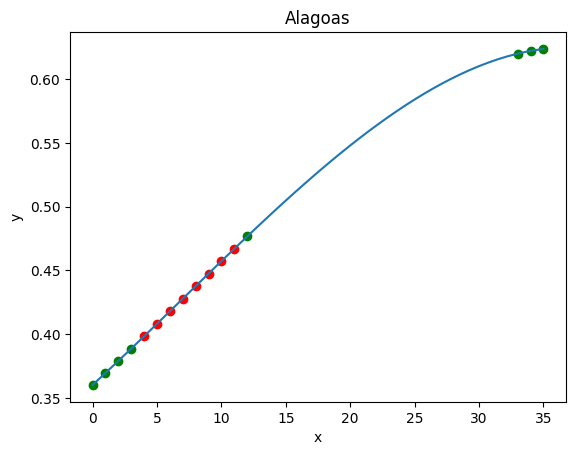

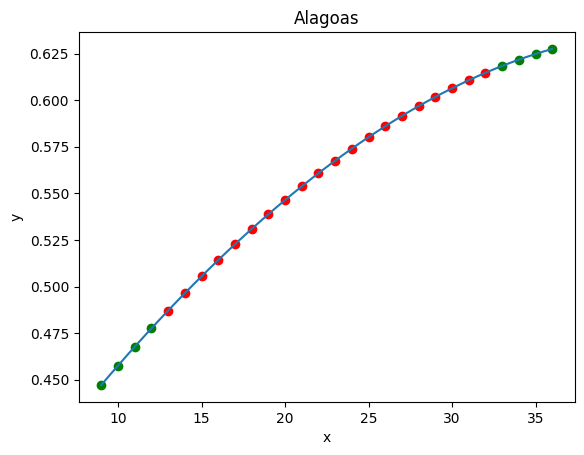

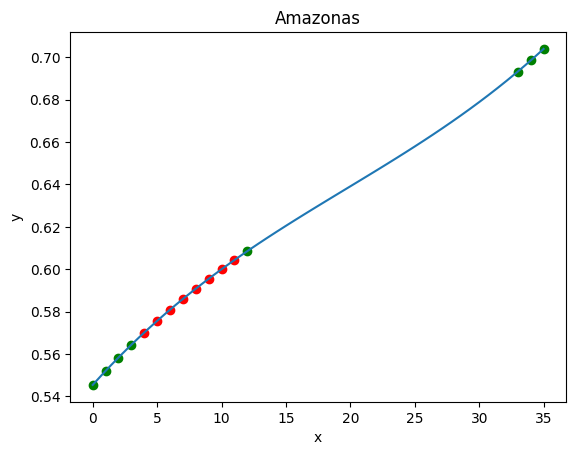

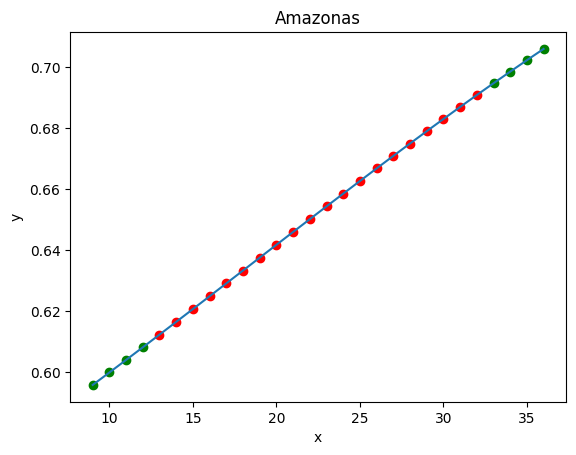

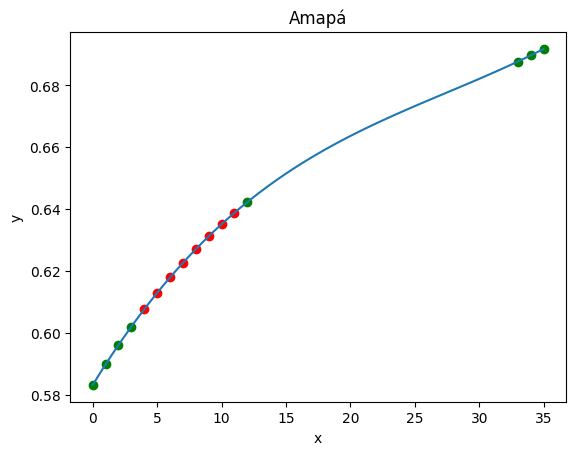

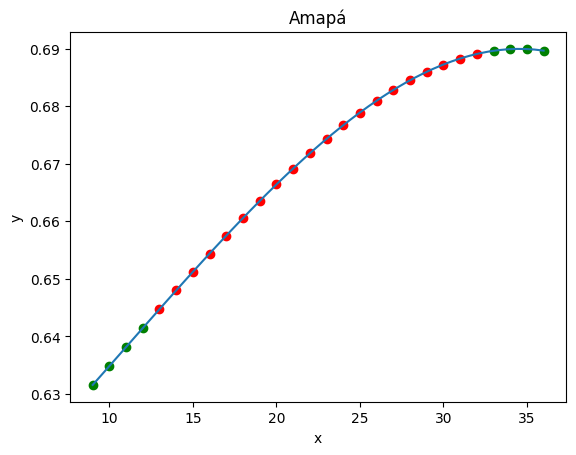

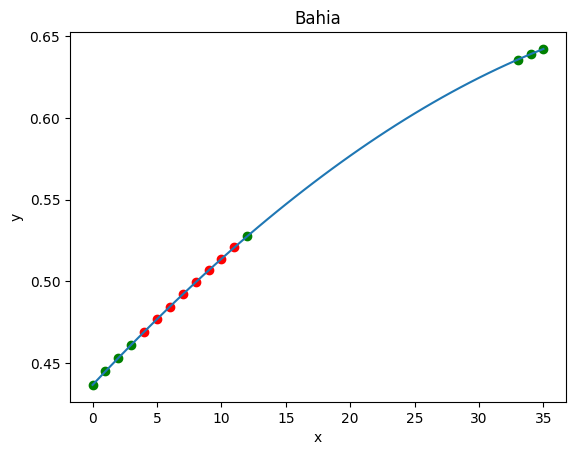

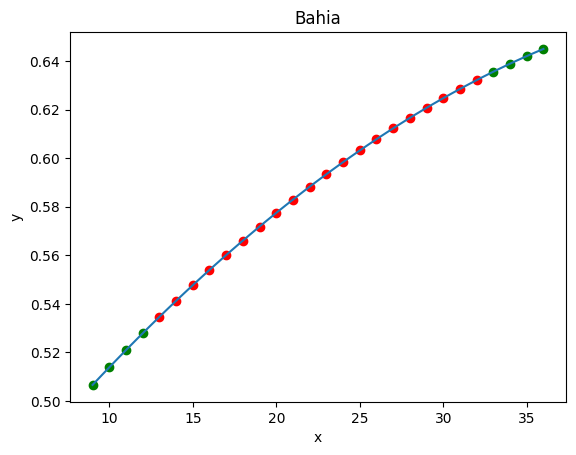

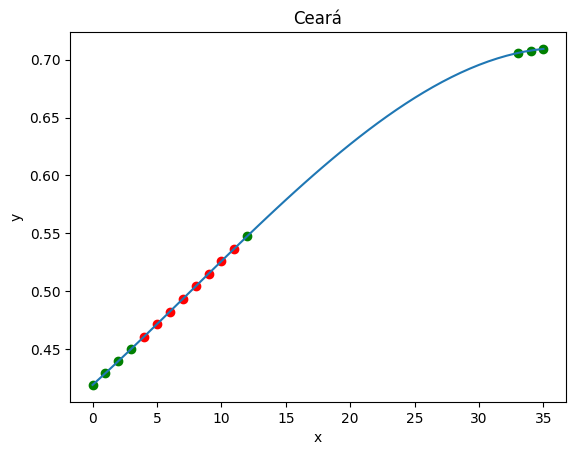

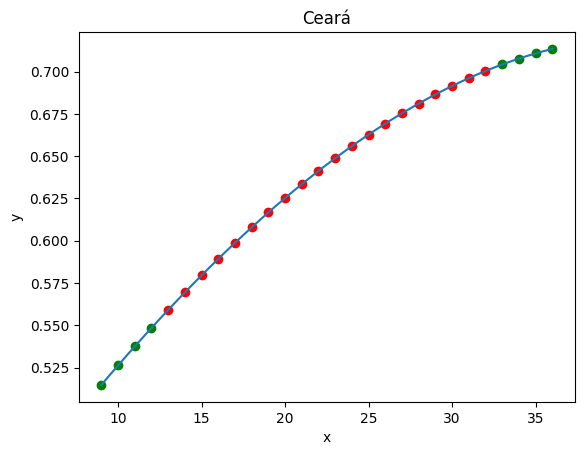

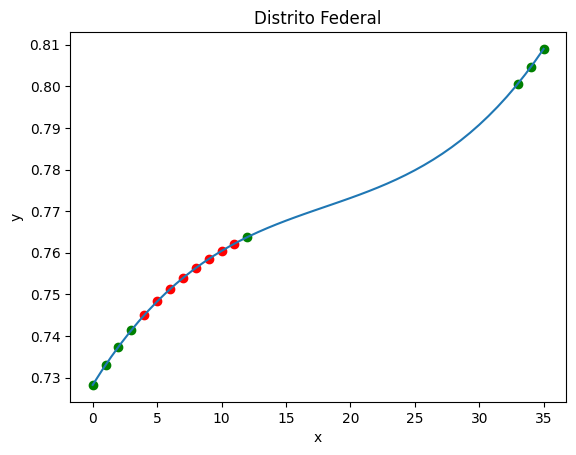

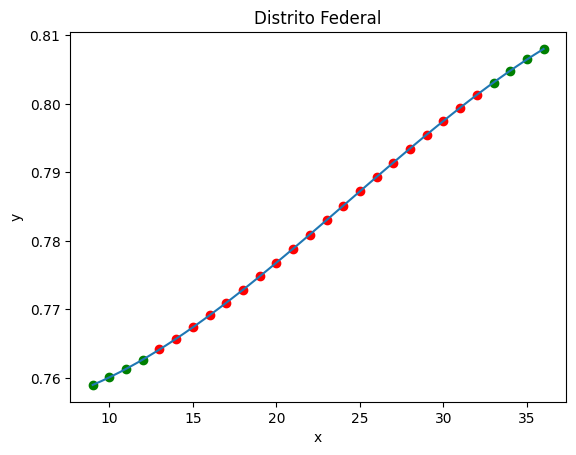

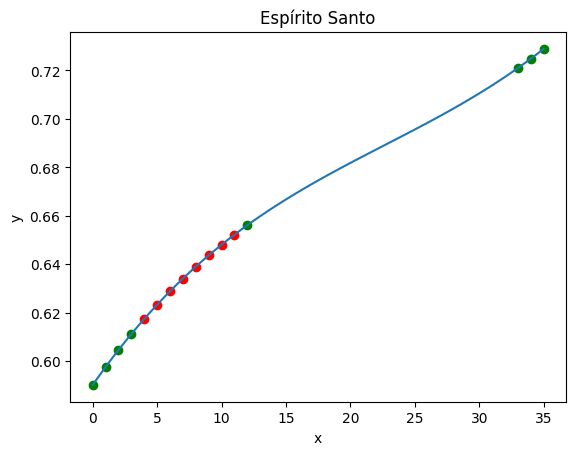

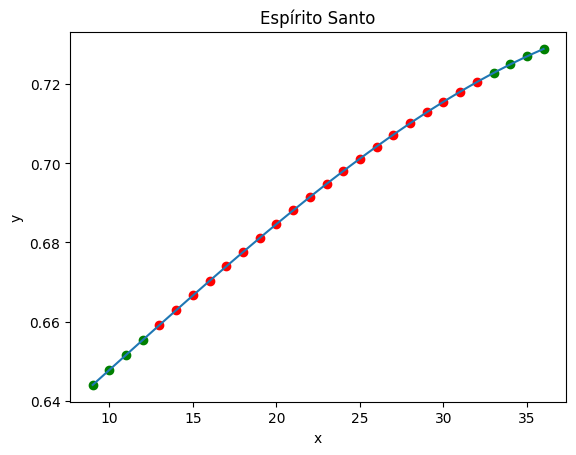

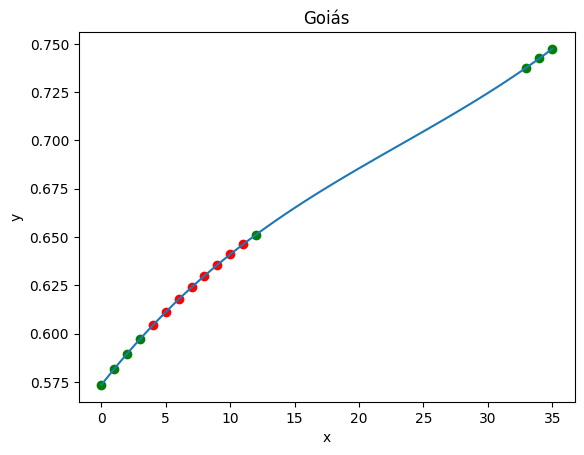

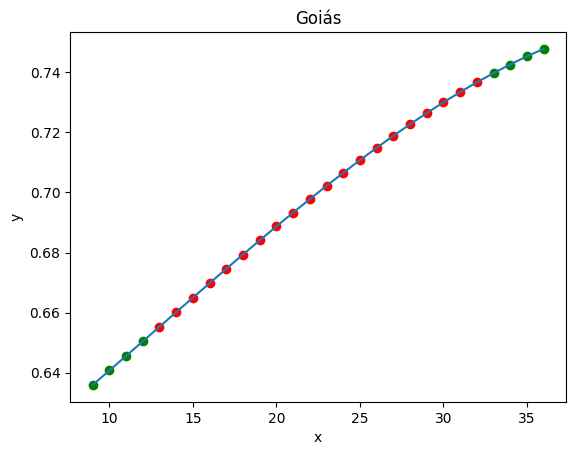

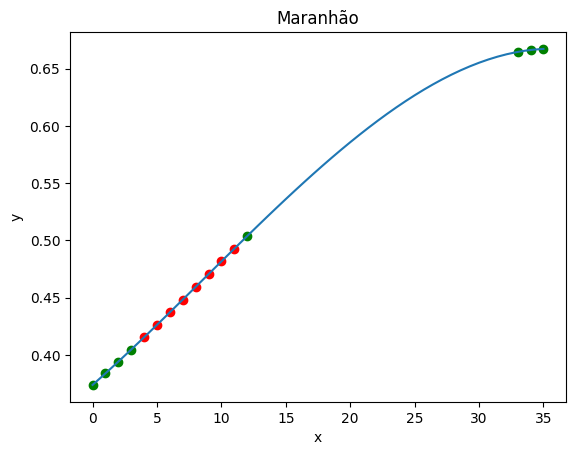

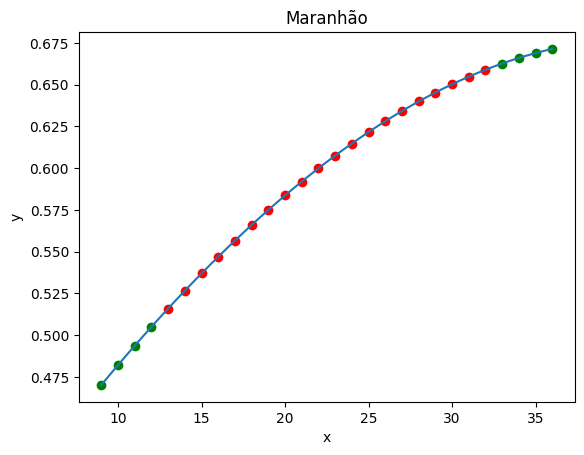

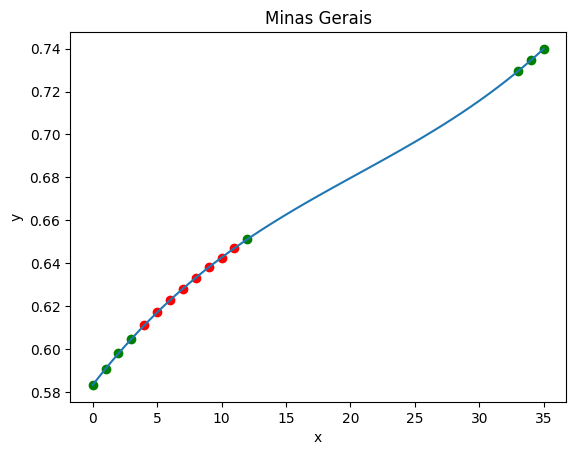

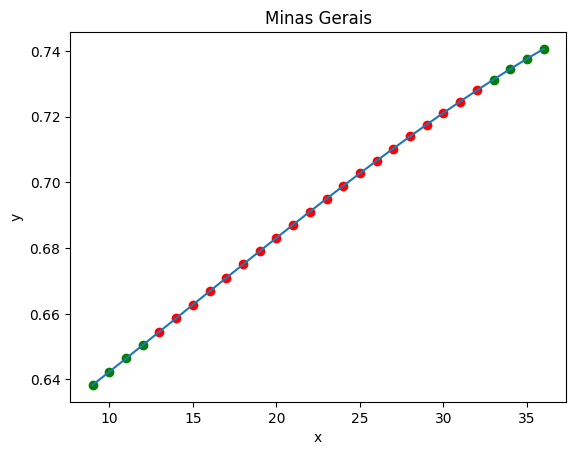

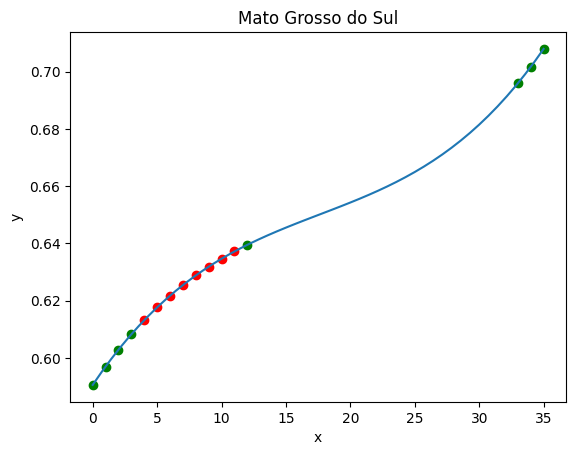

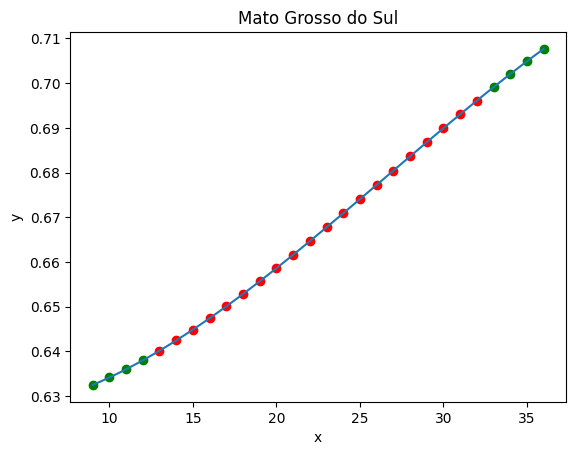

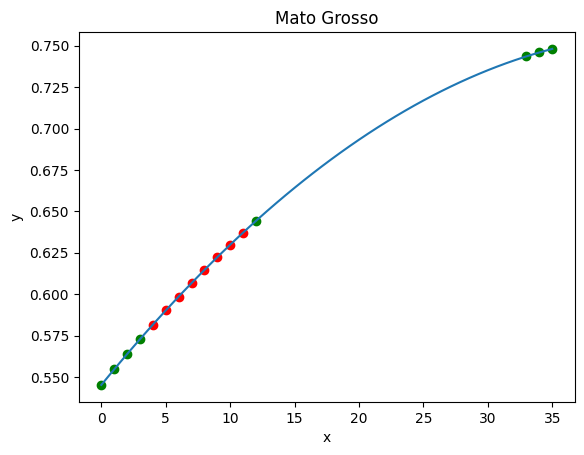

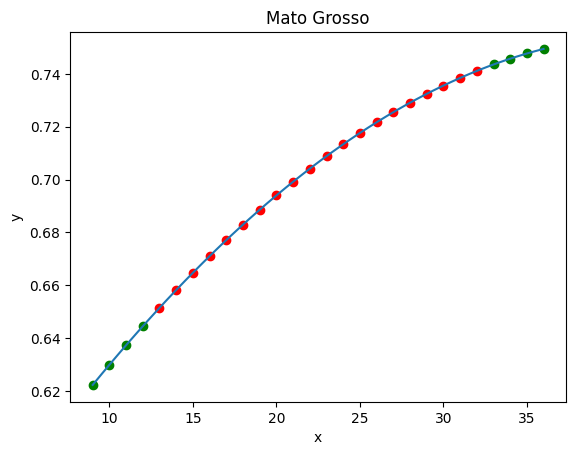

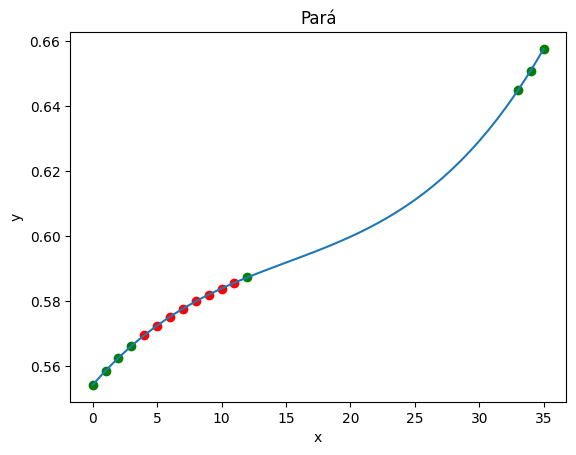

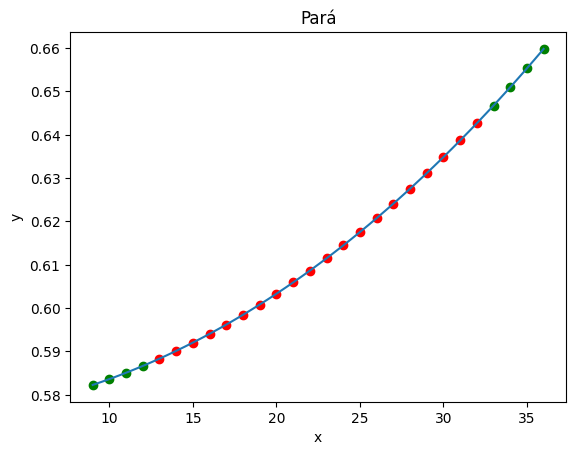

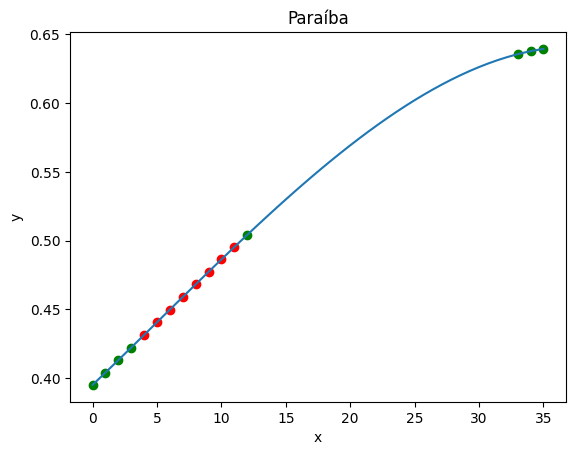

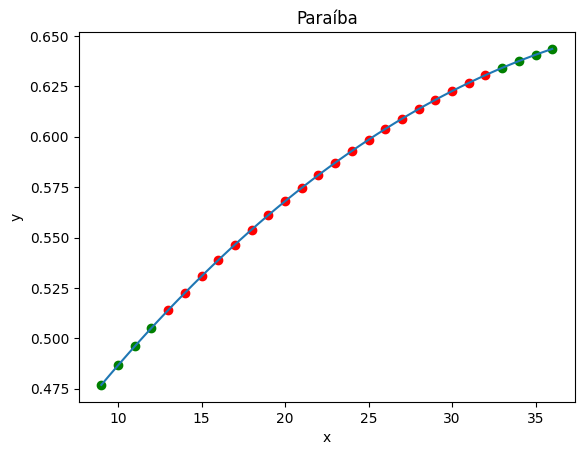

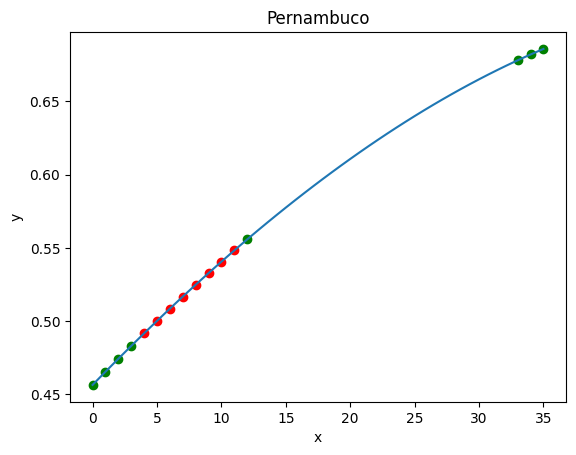

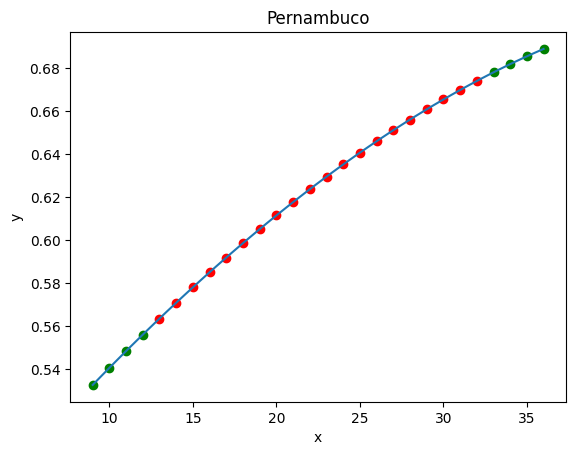

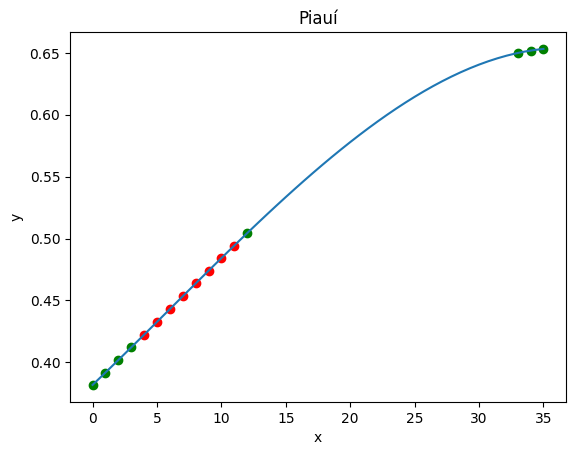

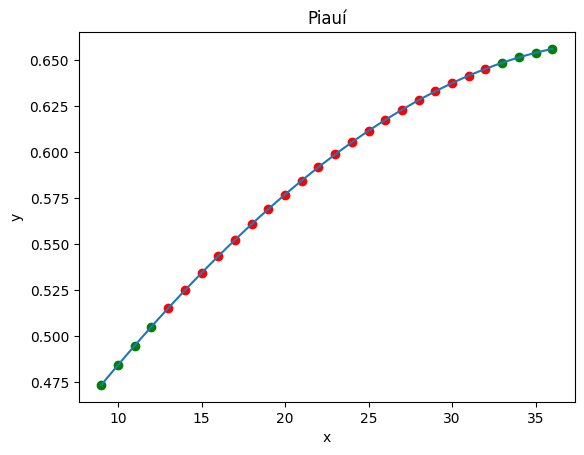

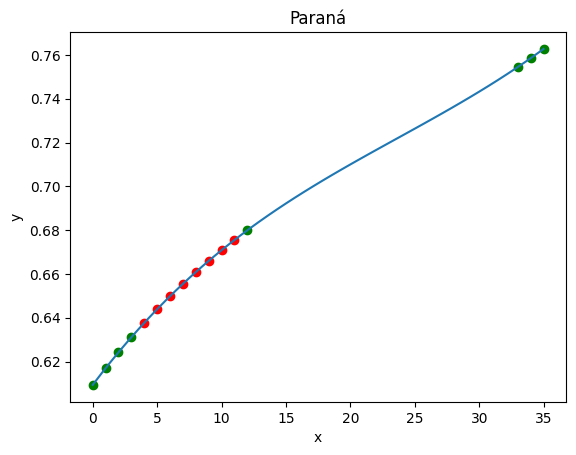

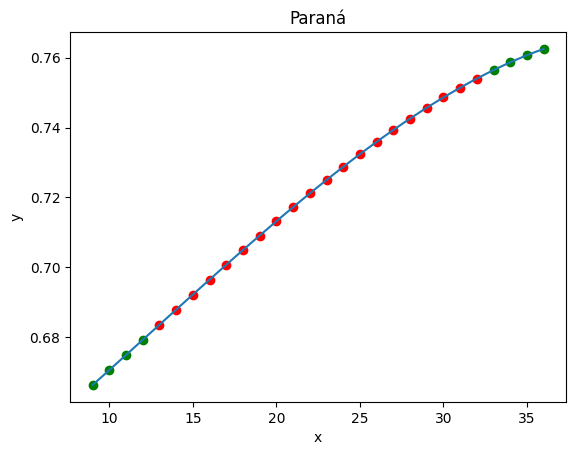

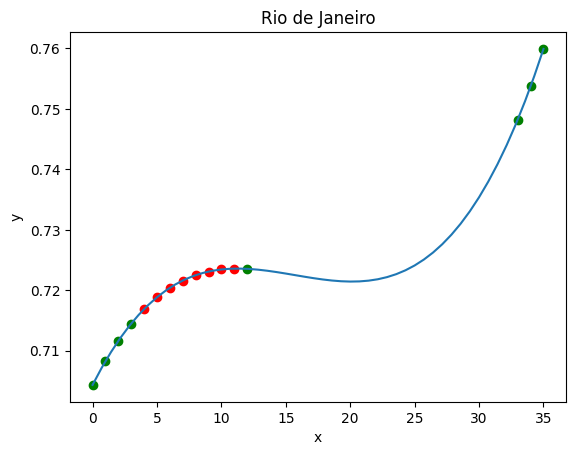

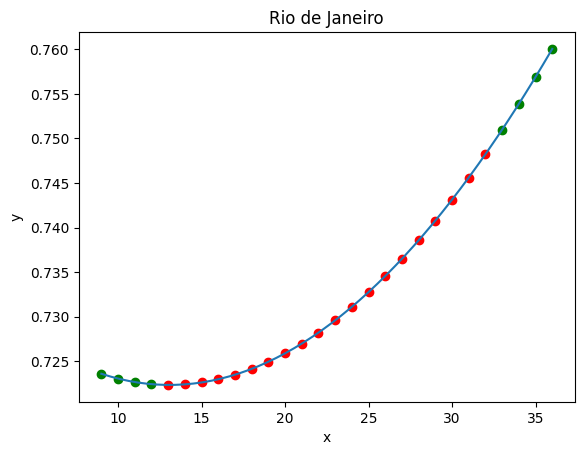

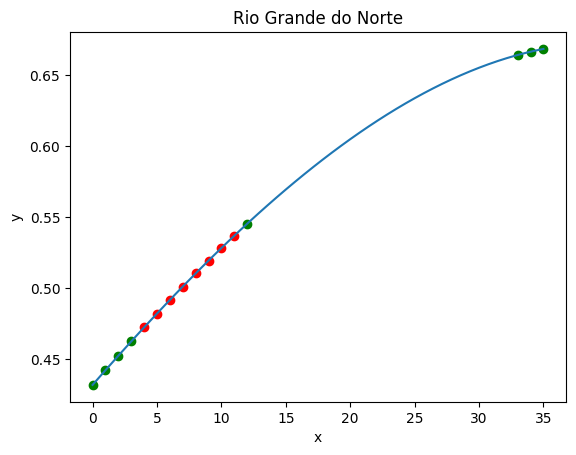

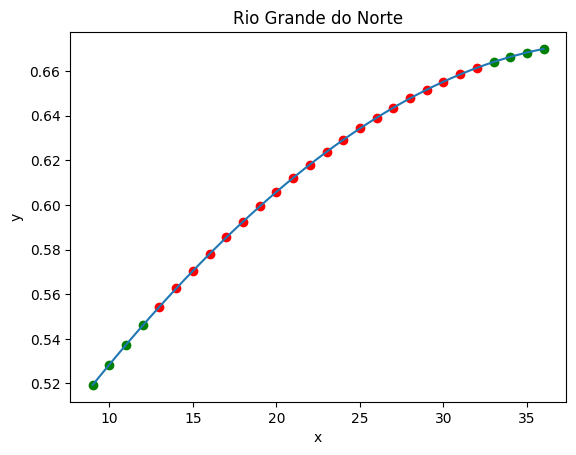

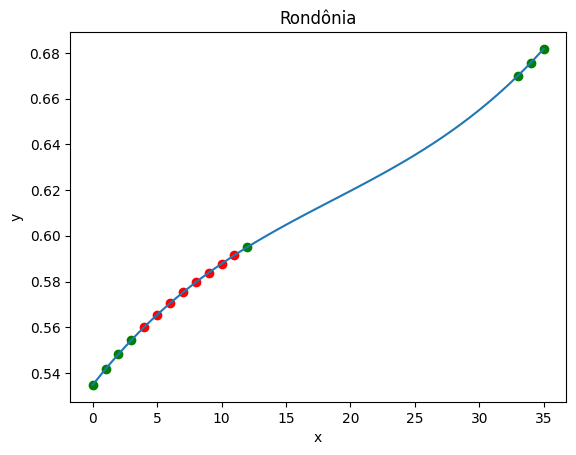

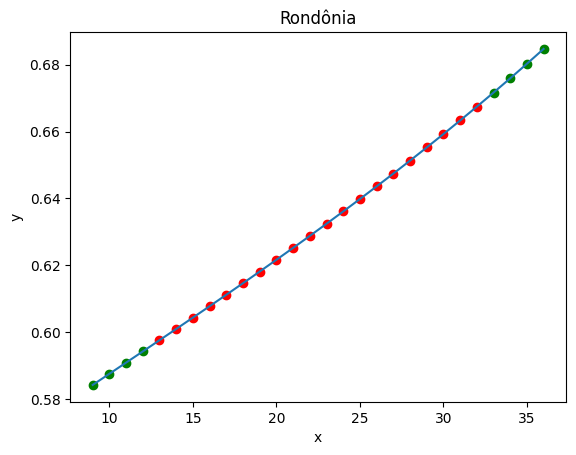

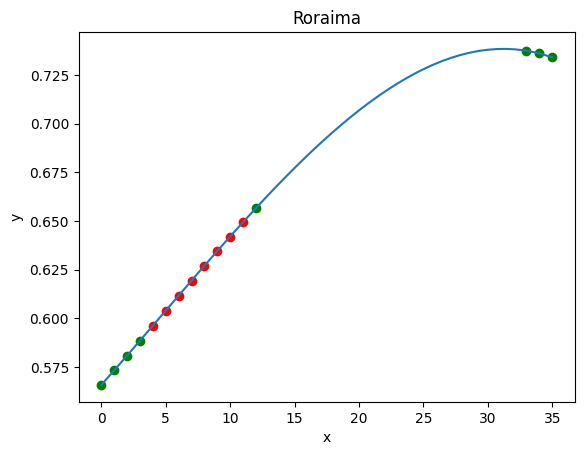

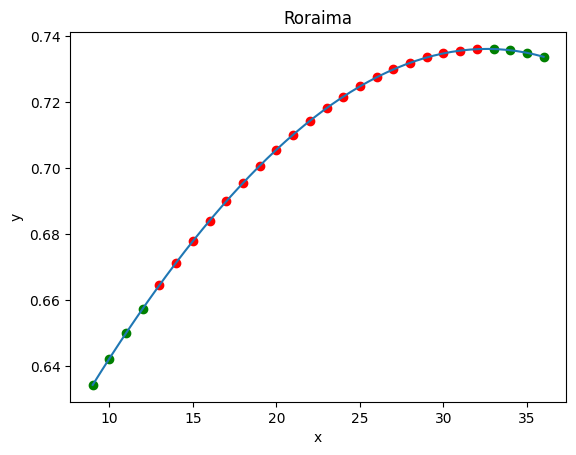

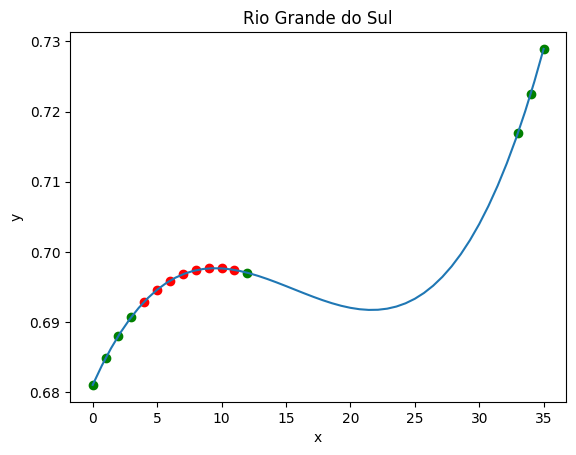

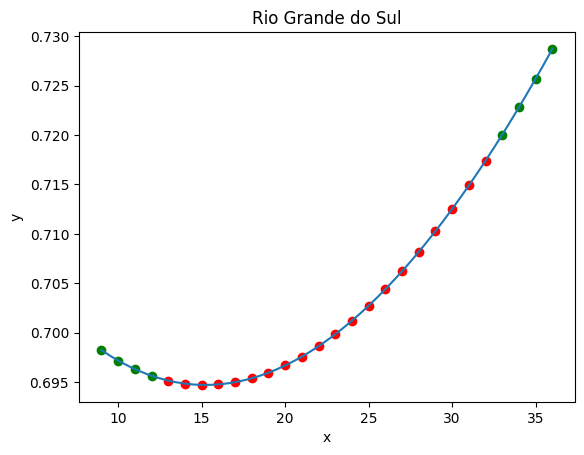

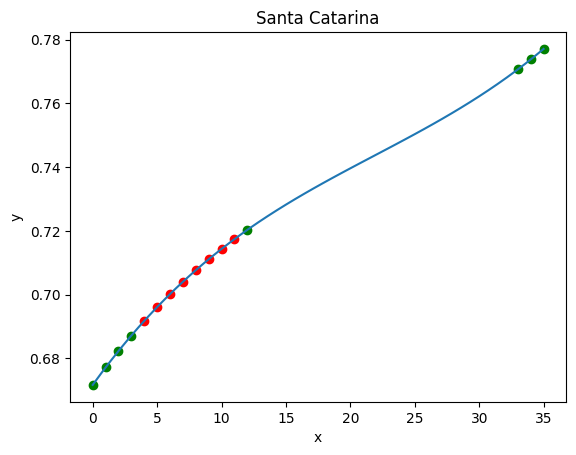

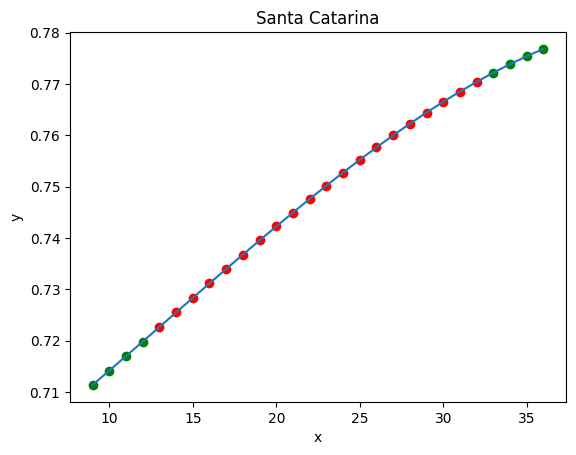

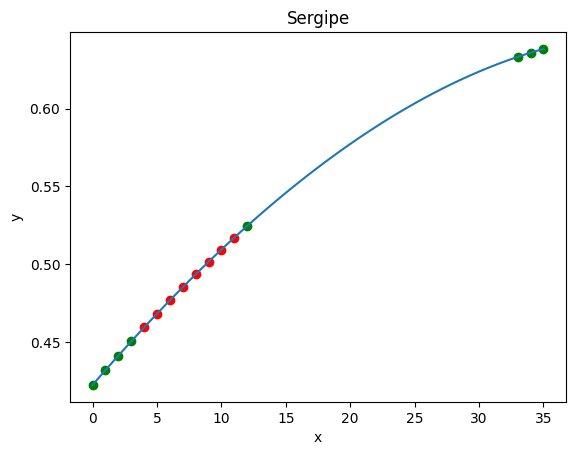

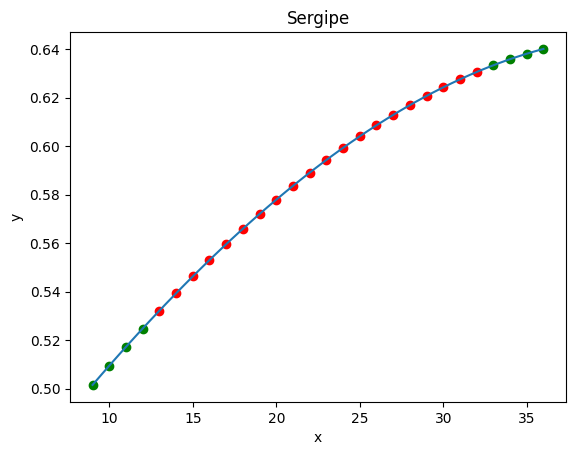

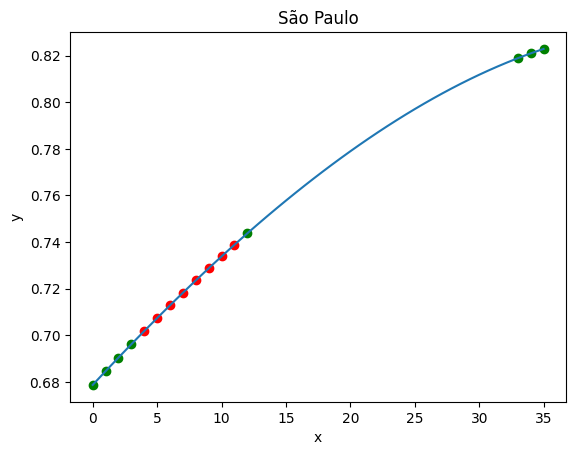

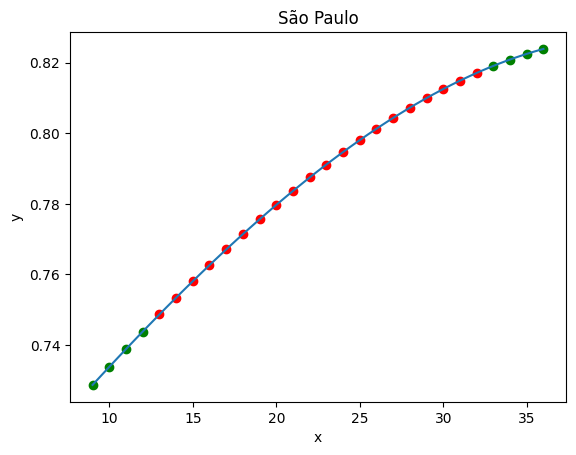

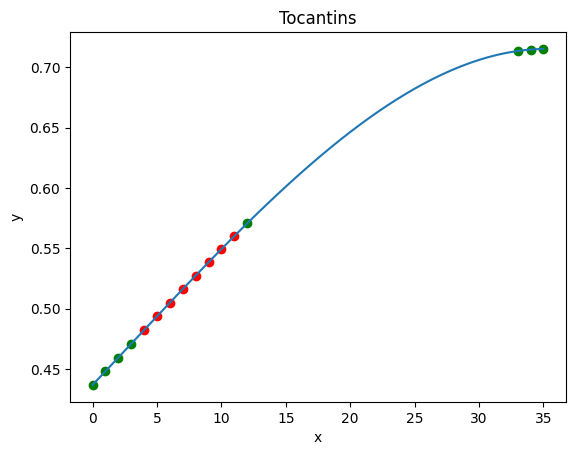

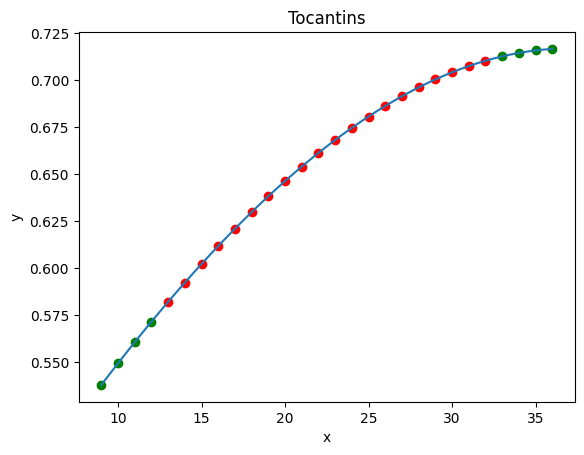

,Acre - IDH Educacao,Alagoas - IDH Educacao,Amazonas - IDH Educacao,Amapá - IDH Educacao,Bahia - IDH Educacao,Ceará - IDH Educacao,Distrito Federal - IDH Educacao,Espírito Santo - IDH Educacao,Goiás - IDH Educacao,Maranhão - IDH Educacao,...,Paraná - IDH Educacao,Rio de Janeiro - IDH Educacao,Rio Grande do Norte - IDH Educacao,Rondônia - IDH Educacao,Roraima - IDH Educacao,Rio Grande do Sul - IDH Educacao,Santa Catarina - IDH Educacao,Sergipe - IDH Educacao,São Paulo - IDH Educacao,Tocantins - IDH Educacao
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.427909,0.359327,0.540945,0.577455,0.434236,0.416964,0.722418,0.584709,0.567655,0.372982,...,0.603327,0.699836,0.429091,0.531455,0.564036,0.675527,0.667600,0.419800,0.676200,0.435055
1980,0.444891,0.374193,0.556735,0.594945,0.449284,0.435356,0.737502,0.602651,0.587385,0.389178,...,0.622993,0.710804,0.448109,0.543345,0.578844,0.687833,0.681120,0.435960,0.688440,0.453665
1981,0.450469,0.379431,0.560081,0.598335,0.453940,0.440228,0.739802,0.606781,0.592063,0.394414,...,0.626591,0.713564,0.453331,0.549815,0.581412,0.690399,0.683944,0.442152,0.691328,0.459799
1982,0.455327,0.384008,0.562916,0.601183,0.457983,0.444419,0.741690,0.610301,0.596057,0.398969,...,0.629600,0.715932,0.457833,0.555559,0.583549,0.692570,0.686333,0.447582,0.693794,0.465140
1983,0.470420,0.398490,0.570115,0.607592,0.469085,0.460828,0.745014,0.617421,0.604391,0.415517,...,0.637673,0.716891,0.472424,0.560084,0.596320,0.692886,0.691780,0.459320,0.701808,0.482201
1984,0.480625,0.408249,0.575624,0.612887,0.476873,0.471586,0.748295,0.623300,0.611231,0.426365,...,0.643910,0.718851,0.482176,0.565452,0.604028,0.694598,0.696111,0.468124,0.707374,0.493574
1985,0.490795,0.418055,0.580899,0.617880,0.484528,0.482419,0.751260,0.628843,0.617755,0.437329,...,0.649841,0.720415,0.491764,0.570486,0.611733,0.695889,0.700195,0.476748,0.712851,0.504901
1986,0.500910,0.427887,0.585956,0.622585,0.492049,0.493300,0.753932,0.634070,0.623979,0.448379,...,0.655484,0.721619,0.501181,0.575209,0.619411,0.696799,0.704047,0.485189,0.718237,0.516161
1987,0.510952,0.437722,0.590810,0.627015,0.499433,0.504203,0.756337,0.638999,0.629920,0.459485,...,0.660855,0.722501,0.510419,0.579647,0.627041,0.697368,0.707681,0.493445,0.723530,0.527331


In [17]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df.columns = df.columns + ' - IDH Educacao'
df

In [18]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre - IDH Educacao,Alagoas - IDH Educacao,Amazonas - IDH Educacao,Amapá - IDH Educacao,Bahia - IDH Educacao,Ceará - IDH Educacao,Distrito Federal - IDH Educacao,Espírito Santo - IDH Educacao,Goiás - IDH Educacao,Maranhão - IDH Educacao,...,Paraná - IDH Educacao,Rio de Janeiro - IDH Educacao,Rio Grande do Norte - IDH Educacao,Rondônia - IDH Educacao,Roraima - IDH Educacao,Rio Grande do Sul - IDH Educacao,Santa Catarina - IDH Educacao,Sergipe - IDH Educacao,São Paulo - IDH Educacao,Tocantins - IDH Educacao
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.684856,0.625244,0.702586,0.689418,0.642702,0.710814,0.806512,0.727224,0.745598,0.668885,...,0.760987,0.757618,0.669135,0.680412,0.735472,0.726051,0.775791,0.638737,0.822812,0.716833
2015,0.685344,0.627431,0.705552,0.689536,0.644677,0.713466,0.807805,0.728742,0.747481,0.671376,...,0.762152,0.759419,0.669230,0.684863,0.733678,0.728306,0.776440,0.639881,0.823629,0.715819
2016,0.698107,0.643045,0.716221,0.693917,0.655705,0.730642,0.813684,0.735711,0.758668,0.688469,...,0.771114,0.763524,0.679146,0.695058,0.738349,0.732388,0.782298,0.650966,0.832029,0.729669
2017,0.697572,0.643776,0.717241,0.692546,0.655678,0.732700,0.812928,0.736049,0.759092,0.689875,...,0.770943,0.764117,0.679432,0.695427,0.735380,0.733333,0.782053,0.653326,0.831577,0.730275
2018,0.699987,0.644665,0.715900,0.691868,0.655740,0.734309,0.814376,0.736508,0.760555,0.690409,...,0.771574,0.764310,0.679654,0.695102,0.732779,0.733908,0.782421,0.654629,0.832084,0.730391
2019,0.699441,0.644089,0.715800,0.687311,0.655353,0.733792,0.814956,0.735918,0.760878,0.690901,...,0.771081,0.762792,0.678713,0.694202,0.729031,0.733718,0.782641,0.654140,0.832365,0.729427
2020,0.696844,0.644188,0.714054,0.683611,0.653839,0.733227,0.812498,0.735456,0.760049,0.689710,...,0.770361,0.761228,0.677778,0.693039,0.725579,0.733602,0.781609,0.655517,0.830852,0.727829
2021,0.691739,0.642750,0.710968,0.682031,0.650552,0.730248,0.811361,0.733406,0.757326,0.686411,...,0.768485,0.759431,0.674848,0.688497,0.722541,0.733111,0.780846,0.653109,0.829384,0.724632
2022,0.691715,0.639455,0.710147,0.685215,0.649784,0.726998,0.810848,0.732625,0.755447,0.683721,...,0.767438,0.759561,0.674380,0.687997,0.727045,0.731576,0.780013,0.650301,0.828510,0.723962


In [19]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_educ_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)

In [20]:
df_2008 = df[df.index >= 2008]
df_2008

,Acre - IDH Educacao,Alagoas - IDH Educacao,Amazonas - IDH Educacao,Amapá - IDH Educacao,Bahia - IDH Educacao,Ceará - IDH Educacao,Distrito Federal - IDH Educacao,Espírito Santo - IDH Educacao,Goiás - IDH Educacao,Maranhão - IDH Educacao,...,Paraná - IDH Educacao,Rio de Janeiro - IDH Educacao,Rio Grande do Norte - IDH Educacao,Rondônia - IDH Educacao,Roraima - IDH Educacao,Rio Grande do Sul - IDH Educacao,Santa Catarina - IDH Educacao,Sergipe - IDH Educacao,São Paulo - IDH Educacao,Tocantins - IDH Educacao
Ano,,,,,,,,,,,,,,,,,,,,,
2008,0.668008,0.601766,0.678960,0.685967,0.620781,0.686465,0.795527,0.712893,0.726402,0.645315,...,0.745648,0.740781,0.651662,0.655238,0.733615,0.710282,0.764435,0.620749,0.809971,0.700364
2009,0.671723,0.606396,0.682960,0.687230,0.624755,0.691475,0.797514,0.715558,0.729972,0.650266,...,0.748601,0.743129,0.655238,0.659243,0.734851,0.712521,0.766524,0.624297,0.812524,0.704145
2010,0.675049,0.610714,0.686918,0.688267,0.628561,0.696107,0.799450,0.718108,0.733384,0.654819,...,0.751387,0.745612,0.658498,0.663312,0.735694,0.714897,0.768517,0.627591,0.814896,0.707452
2011,0.677982,0.614717,0.690831,0.689067,0.632198,0.700356,0.801325,0.720537,0.736630,0.658970,...,0.753998,0.748230,0.661438,0.667449,0.736139,0.717405,0.770407,0.630627,0.817083,0.710276
2012,0.680191,0.618592,0.694062,0.688823,0.635421,0.704333,0.802661,0.722652,0.739409,0.662311,...,0.755977,0.750390,0.663198,0.672215,0.736249,0.719559,0.771704,0.633403,0.818822,0.711858
2013,0.682790,0.621225,0.699234,0.691309,0.638956,0.707444,0.805550,0.725207,0.742860,0.666586,...,0.759142,0.754339,0.667048,0.675149,0.735436,0.723355,0.774346,0.635603,0.821057,0.714846
2014,0.684856,0.625244,0.702586,0.689418,0.642702,0.710814,0.806512,0.727224,0.745598,0.668885,...,0.760987,0.757618,0.669135,0.680412,0.735472,0.726051,0.775791,0.638737,0.822812,0.716833
2015,0.685344,0.627431,0.705552,0.689536,0.644677,0.713466,0.807805,0.728742,0.747481,0.671376,...,0.762152,0.759419,0.669230,0.684863,0.733678,0.728306,0.776440,0.639881,0.823629,0.715819
2016,0.698107,0.643045,0.716221,0.693917,0.655705,0.730642,0.813684,0.735711,0.758668,0.688469,...,0.771114,0.763524,0.679146,0.695058,0.738349,0.732388,0.782298,0.650966,0.832029,0.729669


In [21]:
for column in df_2008.columns:
    state = column
    file_name = f"2008_01_idh_educ_{state}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)

In [22]:
df_2003 = df[df.index >= 2003]
df_2003

,Acre - IDH Educacao,Alagoas - IDH Educacao,Amazonas - IDH Educacao,Amapá - IDH Educacao,Bahia - IDH Educacao,Ceará - IDH Educacao,Distrito Federal - IDH Educacao,Espírito Santo - IDH Educacao,Goiás - IDH Educacao,Maranhão - IDH Educacao,...,Paraná - IDH Educacao,Rio de Janeiro - IDH Educacao,Rio Grande do Norte - IDH Educacao,Rondônia - IDH Educacao,Roraima - IDH Educacao,Rio Grande do Sul - IDH Educacao,Santa Catarina - IDH Educacao,Sergipe - IDH Educacao,São Paulo - IDH Educacao,Tocantins - IDH Educacao
Ano,,,,,,,,,,,,,,,,,,,,,
2003,0.643805,0.574004,0.658468,0.676675,0.598394,0.655921,0.785137,0.698032,0.706514,0.614766,...,0.728728,0.731110,0.629167,0.636082,0.721714,0.701216,0.752747,0.599319,0.794676,0.674633
2004,0.649379,0.580163,0.662621,0.678890,0.603205,0.662745,0.787245,0.701190,0.710733,0.621633,...,0.732368,0.732766,0.634269,0.639808,0.724839,0.702736,0.755231,0.604086,0.798055,0.680661
2005,0.654591,0.586021,0.666750,0.680939,0.607850,0.669217,0.789347,0.704261,0.714841,0.628126,...,0.735890,0.734562,0.639074,0.643583,0.727597,0.704405,0.757648,0.608617,0.801280,0.686256
2006,0.659437,0.591575,0.670852,0.682809,0.612327,0.675331,0.791434,0.707238,0.718828,0.634240,...,0.739283,0.736498,0.643576,0.647411,0.729983,0.706221,0.759991,0.612906,0.804344,0.691411
2007,0.663911,0.596825,0.674923,0.684489,0.616638,0.681082,0.793497,0.710118,0.722684,0.639972,...,0.742539,0.738571,0.647773,0.651295,0.731990,0.708181,0.762256,0.616951,0.807242,0.696116
2008,0.668008,0.601766,0.678960,0.685967,0.620781,0.686465,0.795527,0.712893,0.726402,0.645315,...,0.745648,0.740781,0.651662,0.655238,0.733615,0.710282,0.764435,0.620749,0.809971,0.700364
2009,0.671723,0.606396,0.682960,0.687230,0.624755,0.691475,0.797514,0.715558,0.729972,0.650266,...,0.748601,0.743129,0.655238,0.659243,0.734851,0.712521,0.766524,0.624297,0.812524,0.704145
2010,0.675049,0.610714,0.686918,0.688267,0.628561,0.696107,0.799450,0.718108,0.733384,0.654819,...,0.751387,0.745612,0.658498,0.663312,0.735694,0.714897,0.768517,0.627591,0.814896,0.707452
2011,0.677982,0.614717,0.690831,0.689067,0.632198,0.700356,0.801325,0.720537,0.736630,0.658970,...,0.753998,0.748230,0.661438,0.667449,0.736139,0.717405,0.770407,0.630627,0.817083,0.710276


In [23]:
for column in df_2003.columns:
    state = column
    file_name = f"2003_01_idh_educ_{state}.csv"
    column_df = df_2003[[column]]
    column_df.to_csv(file_name, index=True)

In [26]:
def dataframe_expanded_interpolation(df):
    expanded_df = pd.DataFrame(columns=df.columns)
    for i, (_, row) in enumerate(df.iterrows()):
        if i > 0:
            expanded_df = pd.concat([expanded_df, pd.DataFrame(columns=df.columns, index=[None] * 11)])
        expanded_df = pd.concat([expanded_df, pd.DataFrame(row).T])
    expanded_df = expanded_df.reset_index(drop=True)
    expanded_df.interpolate(method='linear', axis=0, inplace=True)

    return expanded_df

def add_ano_column(df):
    new_df = df.copy()
    ano_start = 2002
    for i in range(len(new_df)):
        if i % 12 == 0:
            ano_start += 1
        new_df.at[i, 'Ano'] =  str(ano_start)

    return new_df

def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [27]:
pd.set_option('display.max_rows', None)
df_mo_2003 = dataframe_expanded_interpolation(df_2003)
df_mo_2003 = add_ano_column(df_mo_2003)
df_mo_2003 = df_mo_2003.set_index('Ano', inplace=False)
df_mo_2003 = add_month(df_mo_2003)
df_mo_2003

,Acre - IDH Educacao,Alagoas - IDH Educacao,Amazonas - IDH Educacao,Amapá - IDH Educacao,Bahia - IDH Educacao,Ceará - IDH Educacao,Distrito Federal - IDH Educacao,Espírito Santo - IDH Educacao,Goiás - IDH Educacao,Maranhão - IDH Educacao,...,Paraná - IDH Educacao,Rio de Janeiro - IDH Educacao,Rio Grande do Norte - IDH Educacao,Rondônia - IDH Educacao,Roraima - IDH Educacao,Rio Grande do Sul - IDH Educacao,Santa Catarina - IDH Educacao,Sergipe - IDH Educacao,São Paulo - IDH Educacao,Tocantins - IDH Educacao
2003-1,0.643805,0.574004,0.658468,0.676675,0.598394,0.655921,0.785137,0.698032,0.706514,0.614766,...,0.728728,0.731110,0.629167,0.636082,0.721714,0.701216,0.752747,0.599319,0.794676,0.674633
2003-2,0.644270,0.574517,0.658814,0.676859,0.598795,0.656490,0.785313,0.698295,0.706866,0.615338,...,0.729031,0.731248,0.629592,0.636393,0.721974,0.701343,0.752954,0.599716,0.794957,0.675135
2003-3,0.644734,0.575030,0.659160,0.677044,0.599196,0.657059,0.785489,0.698558,0.707217,0.615910,...,0.729334,0.731386,0.630017,0.636703,0.722235,0.701470,0.753161,0.600113,0.795239,0.675638
2003-4,0.645199,0.575544,0.659506,0.677228,0.599597,0.657627,0.785664,0.698821,0.707569,0.616483,...,0.729638,0.731524,0.630443,0.637014,0.722495,0.701596,0.753368,0.600511,0.795521,0.676140
2003-5,0.645663,0.576057,0.659852,0.677413,0.599998,0.658196,0.785840,0.699084,0.707920,0.617055,...,0.729941,0.731662,0.630868,0.637324,0.722756,0.701723,0.753575,0.600908,0.795802,0.676642
2003-6,0.646128,0.576570,0.660198,0.677598,0.600399,0.658765,0.786016,0.699348,0.708272,0.617627,...,0.730245,0.731800,0.631293,0.637635,0.723016,0.701850,0.753782,0.601305,0.796084,0.677145
2003-7,0.646592,0.577083,0.660544,0.677782,0.600800,0.659333,0.786191,0.699611,0.708624,0.618199,...,0.730548,0.731938,0.631718,0.637945,0.723277,0.701976,0.753989,0.601703,0.796366,0.677647
2003-8,0.647056,0.577596,0.660891,0.677967,0.601201,0.659902,0.786367,0.699874,0.708975,0.618772,...,0.730851,0.732076,0.632143,0.638255,0.723537,0.702103,0.754196,0.602100,0.796647,0.678149
2003-9,0.647521,0.578110,0.661237,0.678152,0.601602,0.660471,0.786543,0.700137,0.709327,0.619344,...,0.731155,0.732214,0.632568,0.638566,0.723797,0.702229,0.754403,0.602497,0.796929,0.678652
2003-10,0.647985,0.578623,0.661583,0.678336,0.602002,0.661039,0.786718,0.700400,0.709679,0.619916,...,0.731458,0.732352,0.632994,0.638876,0.724058,0.702356,0.754610,0.602895,0.797211,0.679154


In [30]:
for column in df_mo_2003.columns:
    file_name = f"2003_mo_idh_{column}.csv"
    column_df = df_mo_2003[[column]]
    column_df.to_csv(file_name, index=True)